In [26]:
import os
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time
import fredapi as fa
import pandas_ta as ta
from datetime import datetime
# from sklearn.linear_model import LinearRegression


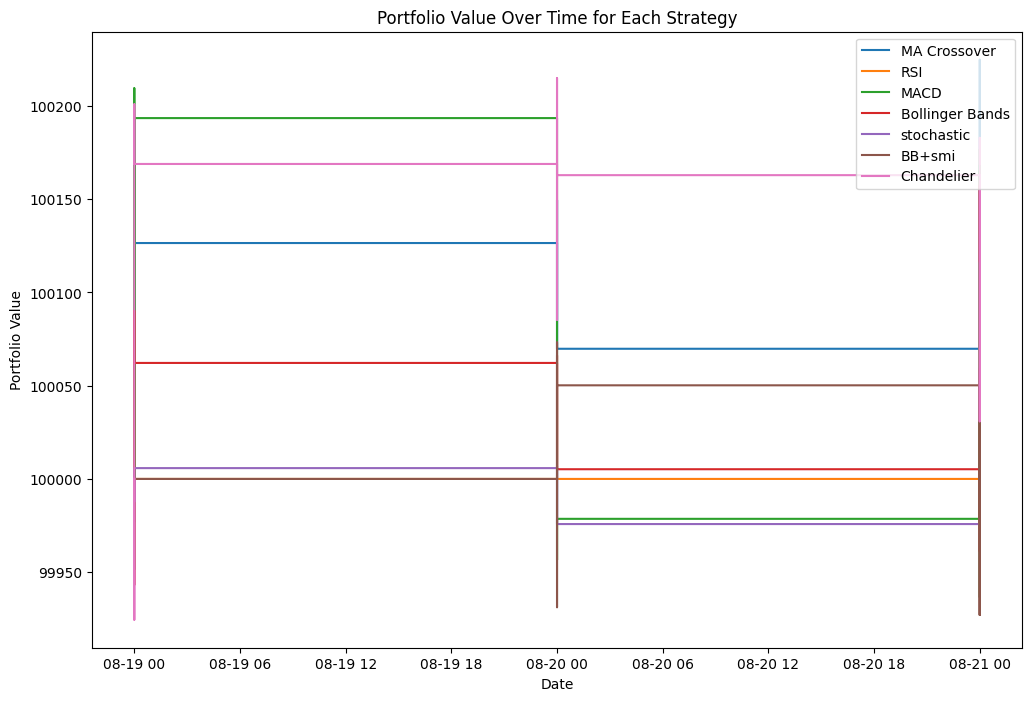

In [28]:
# 1.load data，standardize columns, date&time
directory = "C:/Users/chenl/market data export/MINUTE/"
SPY = pd.read_csv(directory + "SPY.csv", parse_dates=["date"])
SPY['time'] = SPY['date'].dt.time
SPY['date'] = pd.to_datetime(SPY['date'].dt.date)
# Set the multi-level index using the date and time columns
SPY['time'] = SPY['time'].astype(str).str.zfill(8)
SPY.set_index(['date', 'time'], inplace=True)

# Filter 9:30-16:00
SPY = SPY.loc[(SPY.index.get_level_values('time') >= '09:30:00') & 
              (SPY.index.get_level_values('time') <= '16:00:00')&
              (SPY.index.get_level_values('date') >= pd.to_datetime('2024-08-18'))&
              (SPY.index.get_level_values('date') <= pd.to_datetime('2024-08-21'))
              ]
SPY
# 2. create intraday indicators value columns
#define ewm function for mannual SMI calcualtion 
def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()
def intraday_indicators(group):
    # SMA
    group['SMA_5'] = ta.sma(group['close'], length=5)
    group['SMA_9'] = ta.sma(group['close'], length=9)
    group['SMA_18'] = ta.sma(group['close'], length=18)
    group['SMA_50'] = ta.sma(group['close'], length=50)
    group['SMA_100'] = ta.sma(group['close'], length=100) #use 50 and 100 to found cloud, bearish if 50 is below 100, bull if 50 is above 100
    
    # ADX: Calculate the ADX using high, low, and close prices,
    #+DI > -DI: The trend is upward. -DI > +DI: The trend is downward.
    #0-25: Weak or no trend. 25-50: Strong trend. 50-75: Very strong trend. 75-100: Extremely strong trend.
    group['ADX'] = ta.adx(SPY['high'], SPY['low'], SPY['close'], length=20)['ADX_20']
    
    #RSI 
    group['RSI_21'] = ta.rsi(group['close'], length=21)

    #MACD: create new dp with multiple columne then merge back
    macd = ta.macd(group['close'], fast=12, slow=26, signal=9)
    group['MACD'] = macd['MACD_12_26_9']
    group['MACD_hist'] = macd['MACDh_12_26_9']
    group['MACD_signal'] = macd['MACDs_12_26_9']

    #bollinger: create new dp with multiple columne then merge back
    bollinger = ta.bbands(group['close'], length=20, std=2)
    group['Bollinger_upper'] = bollinger['BBU_20_2.0']
    group['Bollinger_middle'] = bollinger['BBM_20_2.0']
    group['Bollinger_lower'] = bollinger['BBL_20_2.0']
    group['Bollinger_width'] = (bollinger['BBU_20_2.0']-bollinger['BBL_20_2.0'])/bollinger['BBM_20_2.0']
    
    # ATR - volatility measure, max up and down range, used for gain collection stop loss 
    group["ATR"]=ta.atr(group.high, group.low, group.close, length =14)
    group["rolling_std_14"]=group["close"].pct_change().rolling(window=14).std()*group["close"]
    # Calculate Chandelier Exit
    group['Chandelier_Exit'] = group['high'].rolling(window=30).max() - group['ATR'] * 1.2
     
    # SMI: difference between the current closing and the median high/low price range over a specified period the k period. 
    # This difference is then divided by the absolute value of the high/low range and multiplied by 100
    # SMI line crosses above the signal line, considered bullish, when the SMI line crosses below the signal line, a bearish signal
    # relativeRange = close - (highestHigh + lowestLow) / 2; double exponential moving average: ds = EMA(EMA(relativeRange, D);
    # dhl = EMA(EMA((highestHigh - lowestLow), D; smi = 200 * (ds / dhl); signal = EMA(smi, EMA period)
    # Calculate SMI manually
    k_period = 14
    d_period = 5
    ema_period = 3   
    # Determine the highest high and lowest low within the K period
    group['highestHigh'] = group['high'].rolling(window=k_period).max()
    group['lowestLow'] = group['low'].rolling(window=k_period).min()
    # Calculate relative range
    group['relativeRange'] = group['close'] - (group['highestHigh'] + group['lowestLow']) / 2
    # Calculate double exponential moving averages
    group['ds'] = ema(ema(group['relativeRange'], d_period), d_period)
    group['dhl'] = ema(ema(group['highestHigh'] - group['lowestLow'], d_period), d_period)
    # Calculate SMI
    group['SMI'] = 200 * (group['ds'] / group['dhl'])
    # Calculate Signal line
    group['SMI_signal'] = ema(group['SMI'], ema_period)  

    # warning: the ta package SMI line and signal line calculation is wrong!! don't use it!
    # Stochastic Momentum Index: SMI Line: The main line; Signal line (D); Oscillator (K): smoothed version of the SMI
    # smi = ta.smi(high=group['high'], low=group['low'], close=group['close'], fast_k=5, slow_k=3, slow_d=3)
    # group['SMI'] = smi['SMI_5_20_5']*100 #main line
    # group['SMI_signal'] = smi['SMIs_5_20_5']*100#Signal line (D)
    
    #target change
    group['pct_change_2min'] = group['close'].pct_change(periods=-2) * 100
    group['pct_change_5min'] = group['close'].pct_change(periods=-5) * 100
    group['pct_change_7min'] = group['close'].pct_change(periods=-7) * 100
    group['pct_change_10min'] = group['close'].pct_change(periods=-10) * 100
    group['pct_change_20min'] = group['close'].pct_change(periods=-20) * 100
    group['pct_change_30min'] = group['close'].pct_change(periods=-30) * 100

    #target direction
    group['direction_2min'] = np.sign(group['close'].shift(-2) - group['close'])
    group['direction_5min'] = np.sign(group['close'].shift(-5) - group['close'])
    group['direction_7min'] = np.sign(group['close'].shift(-7) - group['close'])
    group['direction_10min'] = np.sign(group['close'].shift(-10) - group['close'])
    group['direction_20min'] = np.sign(group['close'].shift(-20) - group['close'])
    group['direction_30min'] = np.sign(group['close'].shift(-30) - group['close']) 
    return group

# Reset the index, group by the 'date' column, apply the function, and set the multi-level index again
SPY.reset_index(inplace=True)
SPY = SPY.groupby('date').apply(intraday_indicators)
SPY.set_index(['date', 'time'], inplace=True)

# 3. generate signals columns for each strategy
def generate_signals(df):
    df['signal_ma'] = 0
    df['signal_rsi'] = 0
    df['signal_macd'] = 0
    df['signal_bollinger'] = 0
    df['signal_stochastic'] = 0
    df["signal_BB+RSI"]=0
    df["signal_Chandelier"]=0
    for date, group in df.groupby('date'):
        for i in range(1, len(group)):            
            if group.iloc[i][['SMA_5', 'SMA_9', 'SMA_18', 'RSI_21', 'MACD', 'MACD_signal', 'Bollinger_lower', 'Bollinger_upper']].isna().any():
                continue
            if group.iloc[i]['SMA_18'] < group.iloc[i]['SMA_50'] and group.iloc[i-1]['SMA_18'] >= group.iloc[i-1]['SMA_50'] and group.iloc[i]["SMA_50"] > group.iloc[i]['SMA_100']:
                df.at[group.index[i], 'signal_ma'] = 1
            elif group.iloc[i]['SMA_50'] < group.iloc[i]['SMA_100'] and group.iloc[i-1]['SMA_50'] >= group.iloc[i-1]['SMA_100']:
                df.at[group.index[i], 'signal_ma'] = -1
            
            if group.iloc[i]['open'] < group.iloc[i]['Bollinger_lower'] and group.iloc[i]['close'] > group.iloc[i]['Bollinger_lower'] and group.iloc[i]["SMA_18"] > group.iloc[i]['SMA_50']:
                df.at[group.index[i], 'signal_bollinger'] = 1
            elif group.iloc[i]['open'] > group.iloc[i]['Bollinger_upper'] and group.iloc[i]['close'] < group.iloc[i]['Bollinger_upper']:
                df.at[group.index[i], 'signal_bollinger'] = -1                  

            if group.iloc[i]['MACD'] > group.iloc[i]['MACD_signal'] and group.iloc[i-1]['MACD'] <= group.iloc[i-1]['MACD_signal'] and group.iloc[i]['MACD']<0:
                df.at[group.index[i], 'signal_macd'] = 1
            elif group.iloc[i]['MACD'] < group.iloc[i]['MACD_signal'] and group.iloc[i-1]['MACD'] >= group.iloc[i-1]['MACD_signal'] and group.iloc[i]['MACD']>0:
                df.at[group.index[i], 'signal_macd'] = -1
        
            if group.iloc[i]['RSI_21'] >= 30 and group.iloc[i-1]['RSI_21'] < 30 and group.iloc[i]["SMA_50"] > group.iloc[i]['SMA_100']:
                df.at[group.index[i], 'signal_rsi'] = 1
            elif group.iloc[i]['RSI_21'] < 55 and group.iloc[i-1]['RSI_21'] >= 55:
                df.at[group.index[i], 'signal_rsi'] = -1
            
            if (group.iloc[i]['SMI'] > group.iloc[i]['SMI_signal'] and group.iloc[i-1]['SMI'] <= group.iloc[i-1]['SMI_signal'] and group.iloc[i]['SMI']<=-30 and group.iloc[i]['MACD']>0) or (group.iloc[i]['SMI']>-40 and group.iloc[i-1]['SMI']<=-40 and group.iloc[i]['MACD']>0):
                df.at[group.index[i], 'signal_stochastic'] = 1
            elif (group.iloc[i]['SMI'] < group.iloc[i]['SMI_signal'] and group.iloc[i-1]['SMI'] >= group.iloc[i-1]['SMI_signal'] and group.iloc[i]['SMI'] >20) or (group.iloc[i]['SMI']>40 and group.iloc[i-1]['SMI']<=40):
                df.at[group.index[i], 'signal_stochastic'] = -1   
            # hybrid
            if group.iloc[i]['SMI'] <-55 and group.iloc[i]['close'] < group.iloc[i]['Bollinger_lower'] and group.iloc[i]['Bollinger_width']> 0.002 :
                df.at[group.index[i], "signal_BB+SMI"] = 1
            elif group.iloc[i]['SMI'] >45 or group.iloc[i]['close'] > group.iloc[i]['Bollinger_upper'] or (group.iloc[i]['SMI'] < group.iloc[i]['SMI_signal'] and group.iloc[i-1]['SMI'] >= group.iloc[i-1]['SMI_signal']):
                df.at[group.index[i], "signal_BB+SMI"] = -1  
            
            #buy and sell signal for chandelier buy and sell
            if group.iloc[i]['close'] > group.iloc[i]['Chandelier_Exit'] and group.iloc[i-1]['MACD'] > group.iloc[i]['MACD_signal']:
                df.at[group.index[i], 'signal_Chandelier'] = 1
            elif group.iloc[i]['close'] < group.iloc[i]['Chandelier_Exit'] and group.iloc[i-1]['MACD'] < group.iloc[i]['MACD_signal']:
                df.at[group.index[i], 'signal_Chandelier'] = -1                

    return df
    
SPY = generate_signals(SPY)

# 4. create logs for each strategy,loop each row

log_ma = []
log_rsi = []
log_macd = []
log_bollinger = []
log_stoch = []
log_BB_SMI=[]
log_Chandelier=[]
log_list=[log_ma,log_rsi,log_macd,log_bollinger,log_stoch,log_BB_SMI,log_Chandelier]

def simulate_trading(df, signal_column, log):
    balance = 100000
    position = 0
    entry_price = None
    portfolio = []
    #adjust for stop loss and profit taking target
    #1 mannual % exit points
    stop_loss=-0.01
    take_profit=0.02
    #2 ATR-based stop loss and take profit factors
    atr_multiplier_stop_loss = 1.5  # Set this to the desired multiple of ATR for stop loss
    atr_multiplier_take_profit = 3.0  # Set this to the desired multiple of ATR for take profit

    # Group the DataFrame by 'date' to simulate day trading, loop each row, enter new trade and closing postion
    for date, group in df.groupby('date'):
        stop_loss_level = None #reset each day
        take_profit_level = None #reset each day
        
        for index, row in group.iterrows(): #loop per minute in each day
            date_str = str(index[0].date())  # Get the date from the index
            time = index[1]  # Get the time from the index
            
            # Open a position if the signal is 1 and no position is currently open
            if row[signal_column] == 1 and position == 0:
                position += 100
                balance -= 100 * row['close']
                entry_price=row["close"]
                # set the ATR-based stop loss and take profit levels for current trade
                stop_loss_level = entry_price - atr_multiplier_stop_loss * row['ATR']
                take_profit_level = entry_price + atr_multiplier_take_profit * row['ATR']
                log.append({'action': 'buy', 'shares': 100, 'price': row['close'], "return":None,'balance': balance,
                            'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
            
            # negative signal: Close the position if the signal is -1 and a position is currently open
            elif row[signal_column] == -1 and position > 0:
                balance += 100 * row['close']
                position -= 100
                price_change=(row["close"]-entry_price)/entry_price
                log.append({'action': 'sell', 'shares': 100, 'price': row['close'],"return":f"{price_change}%", 'balance': balance,
                            'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
                entry_price = None # Reset entry price
            #stop loss and profit taking conditions, select one
            #1 entry price diff % method 
            # if position>0:
            #     price_change=(row["close"]-entry_price)/entry_price
            #     # stop loss
            #     if price_change<=stop_loss:
            #         balance+=100*row["close"]
            #         position-=100
            #         log.append({'action': 'sell to stop', 'shares': 100, 'price': row['close'], "return":f"{price_change}%", 'balance': balance, 
            #                     'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
            #         entry_price=None # Reset entry price
            #     # take profit
            #     elif price_change>=take_profit:
            #         balance += 100 * row['close']
            #         position -= 100
            #         log.append({'action': 'sell to profit', 'shares': 100, 'price': row['close'],"return":f"{price_change}%", 'balance': balance,
            #                     'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
            #         entry_price = None  # Reset entry price
            #2 ATR: x of ATR below or above entry price
            if position>0:
                price_change=(row["close"]-entry_price)/entry_price
                # stop loss
                if row["close"]<=stop_loss_level:
                    balance+=100*row["close"]
                    position-=100
                    log.append({'action': 'sell to stop', 'shares': 100, 'price': row['close'], "return":f"{price_change}%", 'balance': balance, 
                                'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
                    entry_price=None # Reset entry price
                    stop_loss_level = None # Reset
                    take_profit_level = None # Reset                    
                # take profit
                elif price_change>=take_profit_level:
                    balance += 100 * row['close']
                    position -= 100
                    log.append({'action': 'sell to profit', 'shares': 100, 'price': row['close'],"return":f"{price_change}%", 'balance': balance,
                                'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
                    entry_price = None  # Reset entry price
                    stop_loss_level = None # Reset
                    take_profit_level = None # Reset
                    
            #3 Trailing exit: pending
            #4 Volatility Squeeze Exi: pending  
                
            # record the current portfolio value for each row
            portfolio.append(balance + position * row['close'])

        # close: time base; At the EOD, in each date loop, close any remaining open positions
        if position > 0:
            balance += 100 * group.iloc[-1]['close']  # Use the last row's close price to close the position
            price_change=(group.iloc[-1]['close']-entry_price)/entry_price
            log.append({'action': 'sell at EOD', 'shares': 100, 'price': group.iloc[-1]['close'],"return":f"{price_change}%", 'balance': balance, 
                        'portfolio_value': balance, 'date': date_str, 'time': group.index[-1][1]})
            position -= 100  # Reset position to 0, sell 100
            entry_price = None 
    
        # Correct the final portfolio value for the last row of the day
        portfolio[-1] = balance  # Ensure the last entry for the day is correct
        
    df['portfolio_' + signal_column] = portfolio
    return df

# Apply the trading simulation for each strategy
SPY = simulate_trading(SPY, 'signal_ma', log_ma)
SPY = simulate_trading(SPY, 'signal_rsi', log_rsi)
SPY = simulate_trading(SPY, 'signal_macd', log_macd)
SPY = simulate_trading(SPY, 'signal_bollinger', log_bollinger)
SPY = simulate_trading(SPY, 'signal_stochastic', log_stoch)
SPY = simulate_trading(SPY, "signal_BB+SMI", log_BB_SMI)
SPY = simulate_trading(SPY, "signal_Chandelier", log_Chandelier)

#convert log list into dataframe view
log_list = [pd.DataFrame(log) for log in log_list] #convert each log into df
log_ma, log_rsi, log_macd, log_bollinger, log_stoch, log_BB_SMI, log_Chandelier = log_list #reassign value

# Plotting
import matplotlib.dates as mdates

SPY_reset = SPY.reset_index()
plt.figure(figsize=(12, 8))
plt.plot(SPY_reset['date'], SPY_reset['portfolio_signal_ma'], label='MA Crossover')
plt.plot(SPY_reset['date'], SPY_reset['portfolio_signal_rsi'], label='RSI')
plt.plot(SPY_reset['date'], SPY_reset['portfolio_signal_macd'], label='MACD')
plt.plot(SPY_reset['date'], SPY_reset['portfolio_signal_bollinger'], label='Bollinger Bands')
plt.plot(SPY_reset['date'], SPY_reset['portfolio_signal_stochastic'], label='stochastic')
plt.plot(SPY_reset['date'], SPY_reset["portfolio_signal_BB+SMI"], label='BB+smi')
plt.plot(SPY_reset['date'], SPY_reset["portfolio_signal_Chandelier"], label='Chandelier')

plt.title('Portfolio Value Over Time for Each Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.show()


In [12]:
SPY.columns

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_9', 'SMA_18',
       'SMA_50', 'SMA_100', 'ADX', 'RSI_21', 'MACD', 'MACD_hist',
       'MACD_signal', 'Bollinger_upper', 'Bollinger_middle', 'Bollinger_lower',
       'Bollinger_width', 'ATR', 'rolling_std_14', 'Chandelier_Exit',
       'highestHigh', 'lowestLow', 'relativeRange', 'ds', 'dhl', 'SMI',
       'SMI_signal', 'pct_change_2min', 'pct_change_5min', 'pct_change_7min',
       'pct_change_10min', 'pct_change_20min', 'pct_change_30min',
       'direction_2min', 'direction_5min', 'direction_7min', 'direction_10min',
       'direction_20min', 'direction_30min', 'signal_ma', 'signal_rsi',
       'signal_macd', 'signal_bollinger', 'signal_stochastic', 'signal_BB+RSI',
       'signal_Chandelier', 'signal_BB+SMI', 'portfolio_signal_ma',
       'portfolio_signal_rsi', 'portfolio_signal_macd',
       'portfolio_signal_bollinger', 'portfolio_signal_stochastic',
       'portfolio_signal_BB+SMI', 'portfolio_signal_Chandelier'],


In [ ]:
#trade number
# log_ma
# log_rsi
# log_macd
# log_bollinger
# log_stoch
# log_BB_RSI
# log_Chandelier.head(30)

# calculate trades winning rates 

MA Crossover - Total Trade Rounds: 156
MA Crossover - Winning Trade Rounds: 55
MA Crossover - Winning Rate: 35.26%
MA Crossover - Trade Return Distribution:
count    155.000000
mean       0.007169
std        0.089683
min       -0.145358
25%       -0.034928
50%       -0.020429
75%        0.031948
max        0.669695
Name: trade_return, dtype: float64


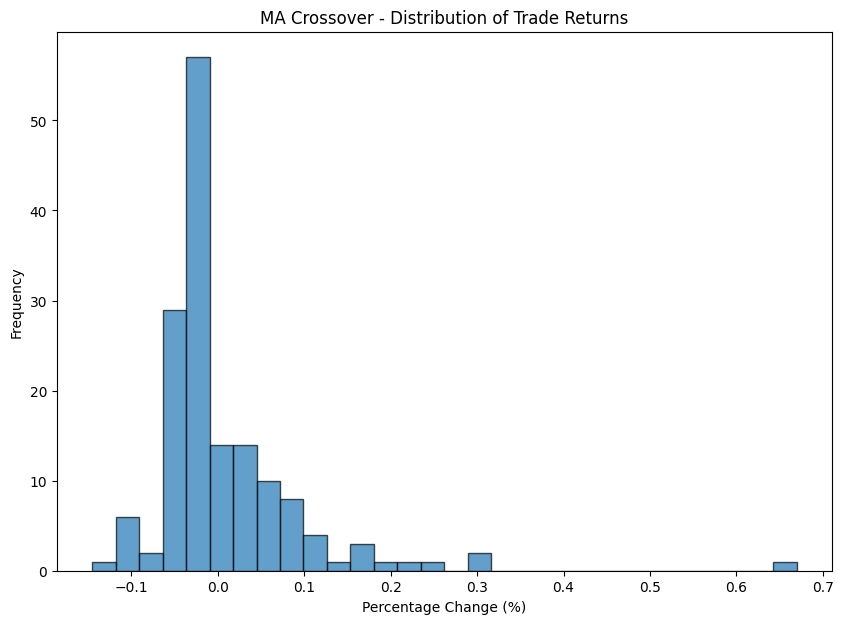

RSI - Total Trade Rounds: 24
RSI - Winning Trade Rounds: 12
RSI - Winning Rate: 50.00%
RSI - Trade Return Distribution:
count    24.000000
mean      0.019738
std       0.087953
min      -0.074810
25%      -0.043828
50%      -0.005509
75%       0.075945
max       0.266787
Name: trade_return, dtype: float64


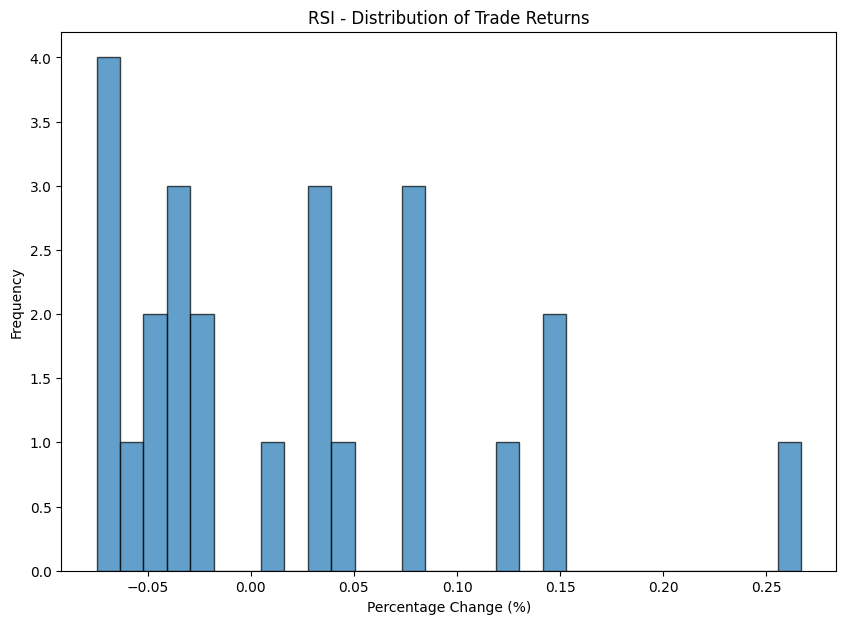

MACD - Total Trade Rounds: 629
MACD - Winning Trade Rounds: 256
MACD - Winning Rate: 40.70%
MACD - Trade Return Distribution:
count    626.000000
mean       0.000920
std        0.066229
min       -0.132194
25%       -0.040858
50%       -0.021679
75%        0.032846
max        0.350771
Name: trade_return, dtype: float64


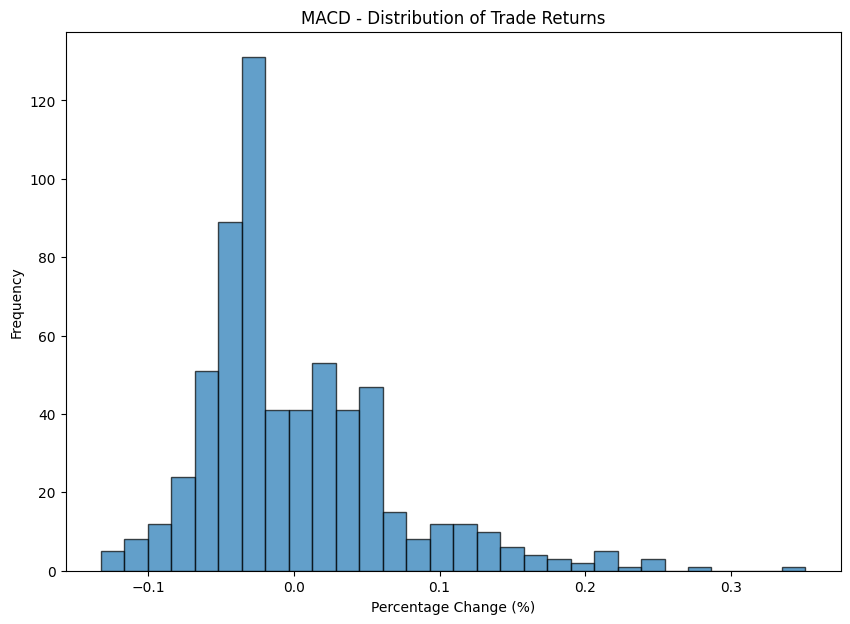

Bollinger Bands - Total Trade Rounds: 175
Bollinger Bands - Winning Trade Rounds: 64
Bollinger Bands - Winning Rate: 36.57%
Bollinger Bands - Trade Return Distribution:
count    173.000000
mean      -0.002127
std        0.068532
min       -0.126983
25%       -0.043654
50%       -0.025578
75%        0.036979
max        0.313445
Name: trade_return, dtype: float64


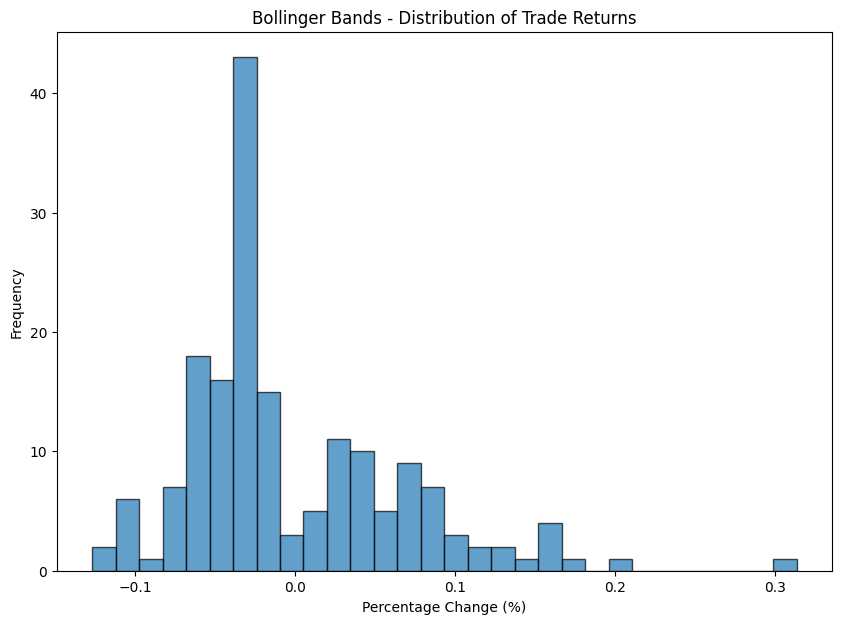

Stochastic - Total Trade Rounds: 56
Stochastic - Winning Trade Rounds: 36
Stochastic - Winning Rate: 64.29%
Stochastic - Trade Return Distribution:
count    56.000000
mean      0.001807
std       0.054911
min      -0.211410
25%      -0.021584
50%       0.007248
75%       0.024167
max       0.193870
Name: trade_return, dtype: float64


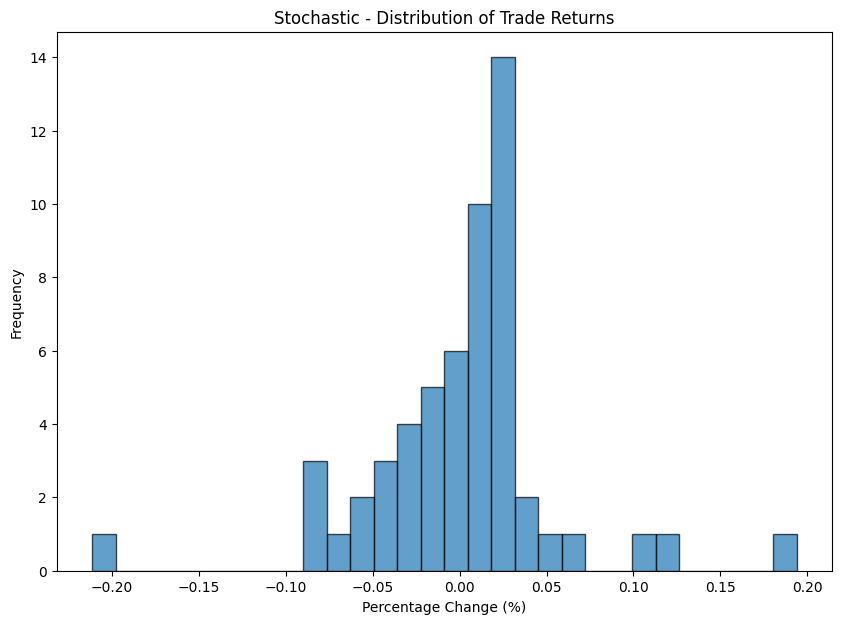

BB_SMI - Total Trade Rounds: 223
BB_SMI - Winning Trade Rounds: 71
BB_SMI - Winning Rate: 31.84%
BB_SMI - Trade Return Distribution:
count    220.000000
mean      -0.013738
std        0.065436
min       -0.143425
25%       -0.056245
50%       -0.030806
75%        0.009734
max        0.249999
Name: trade_return, dtype: float64


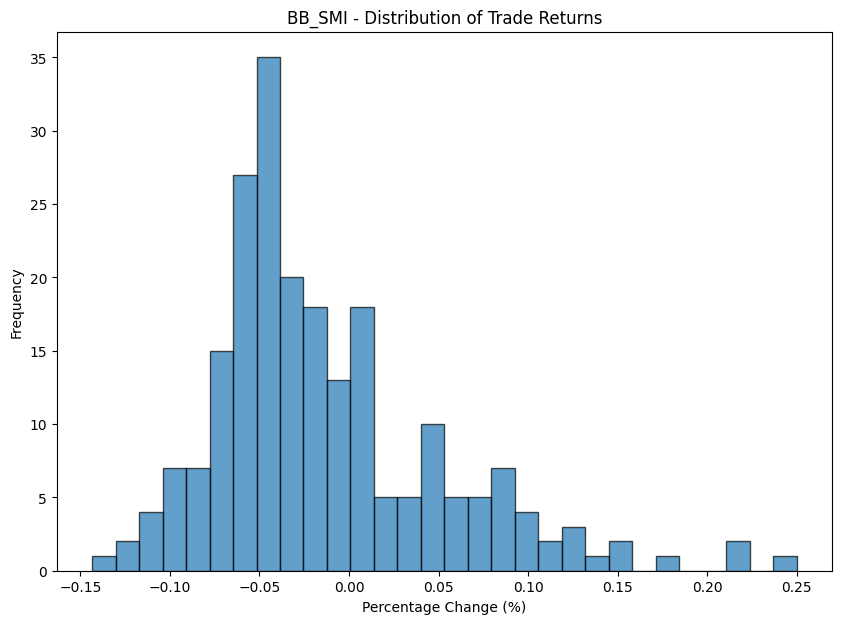

Chandelier - Total Trade Rounds: 766
Chandelier - Winning Trade Rounds: 285
Chandelier - Winning Rate: 37.21%
Chandelier - Trade Return Distribution:
count    759.000000
mean       0.001020
std        0.060840
min       -0.223599
25%       -0.031736
50%       -0.010897
75%        0.020822
max        0.536687
Name: trade_return, dtype: float64


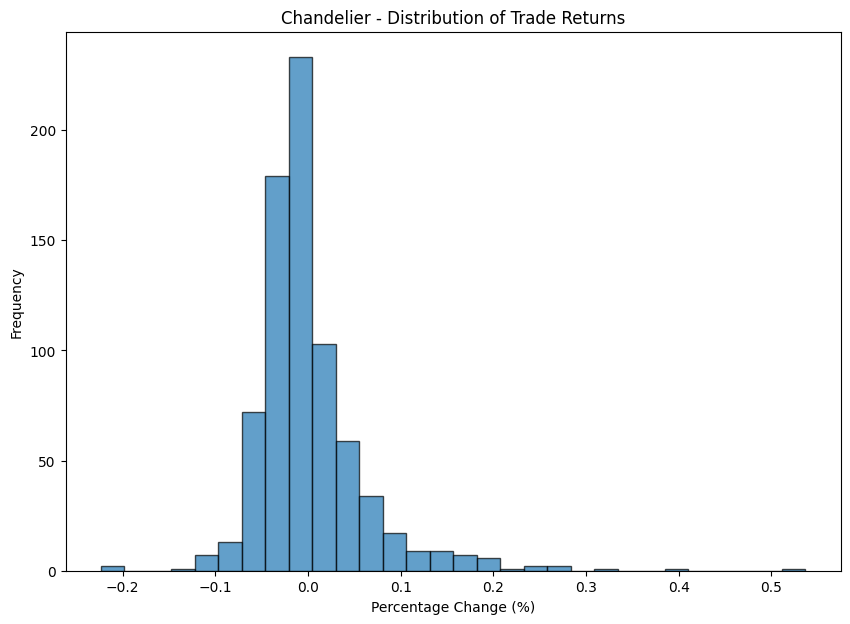

In [5]:
def classify_return(trade_return):
    if trade_return > 0:
        return 1  # Win
    elif trade_return < 0:
        return -1  # Loss
    else:
        return 0  # Neutral
# Function to process each log
def process_log(log, name):
    log_df=log
    # Calculate trade returns as the percentage change in portfolio value
    log_df['trade_return'] = log_df['portfolio_value'].pct_change() * 100
    log_df['trade_return'].fillna(0, inplace=True)

    # Classify each trade as a win, loss, or neutral
    log_df['win_rate'] = log_df['trade_return'].apply(classify_return)

    # Determine total number of trades (pairs of buy and sell)
    if len(log_df) % 2 != 0:
        total_trades = (len(log_df) - 1) // 2
    else:
        total_trades = len(log_df) // 2

    # Calculate winning trades (only count sells trades since they all closed at EOD)
    winning_trades = len(log_df[(log_df['win_rate'] == 1) & (log_df['action'] != 'buy')])

    # Calculate winning rate
    winning_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0

    # Print trade statistics
    print(f"{name} - Total Trade Rounds: {total_trades}")
    print(f"{name} - Winning Trade Rounds: {winning_trades}")
    print(f"{name} - Winning Rate: {winning_rate:.2f}%")
    print(f"{name} - Trade Return Distribution:\n{log_df[log_df['trade_return'] != 0]['trade_return'].describe()}")

    # Plot the distribution of trade returns
    plt.figure(figsize=(10, 7))
    plt.hist(log_df[log_df['trade_return'] != 0]['trade_return'].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{name} - Distribution of Trade Returns')
    plt.xlabel('Percentage Change (%)')
    plt.ylabel('Frequency')
    plt.show()

    return log_df

# Define logs and their names
logs = [log_ma, log_rsi, log_macd, log_bollinger, log_stoch, log_BB_SMI,log_Chandelier]
log_names = ['MA Crossover',"RSI",'MACD', 'Bollinger Bands', 'Stochastic',"BB_SMI","Chandelier"]

# Process each log
for log, name in zip(logs, log_names):
    process_log(log, name)


In [ ]:
log_ma["action"].value_counts()

# distribution of stock movement after signal triggered

In [ ]:
# Filter rows where 'signal_macd' equals 1
df_filtered = SPY[SPY['signal_bollinger'] == 1]

# Plot the distributions
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 4)
plt.hist(df_filtered['pct_change_2min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 2min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 1)
plt.hist(df_filtered['pct_change_5min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 5min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 2)
plt.hist(df_filtered['pct_change_10min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 10min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 3)
plt.hist(df_filtered['pct_change_20min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 20min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 5)
plt.hist(df_filtered['pct_change_30min'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of 30min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate descriptive BB width
# mean_width = SPY['Bollinger_width'].mean()
# median_width =  SPY['Bollinger_width'].median()
# std_width =  SPY['Bollinger_width'].std()
# min_width =  SPY['Bollinger_width'].min()
# max_width =  SPY['Bollinger_width'].max()
# quantiles =  SPY['Bollinger_width'].quantile([0.25, 0.5, 0.75])

# print("Descriptive Statistics for Bollinger Band Width:")
# print(f"Mean: {mean_width}")
# print(f"Median: {median_width}")
# print(f"Standard Deviation: {std_width}")
# print(f"Minimum: {min_width}")
# print(f"Maximum: {max_width}")
# print(f"25th, 50th (median), 75th Percentile:\n{quantiles}")

# # Plot the distribution using a histogram
# plt.figure(figsize=(10, 6))
# plt.hist( SPY['Bollinger_width'].dropna(), bins=30, edgecolor='k', alpha=0.7)
# plt.title('Distribution of Bollinger Band Width')
# plt.xlabel('Bollinger Band Width')
# plt.ylabel('Frequency')
# plt.show()

# # Plot the distribution using a box plot
# plt.figure(figsize=(8, 6))
# plt.boxplot( SPY['Bollinger_width'].dropna(), vert=False)
# plt.title('Box Plot of Bollinger Band Width')
# plt.xlabel('Bollinger Band Width')
# plt.show()

In [ ]:
#decide down trend or up trend before preferance
